## week0_09 practice: PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

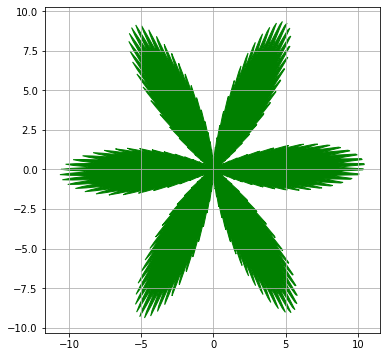

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6*theta)) * (1 + 0.01 * torch.cos(24*theta)) * (0.5 + 0.05 * torch.cos(200*theta)) * (10 + torch.sin(6*theta))
# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task 2: Using the Dataloader

In [3]:
from torch import nn
from torch.nn import functional as F

In [4]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/basic_s20/week0_09_Optimization_and_Regularization_in_DL/notmnist.py -nc

Файл «notmnist.py» уже существует — не загружается.



In [5]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [6]:
# Простейший пример
a = [1,2,3]

In [7]:
# Следующие два методы выполняют тоже самое
print(len(a))
a.__len__()

3


3

In [8]:
# Следующие два методы выполняют тоже самое
print(a[1])
a.__getitem__(1)

2


2

In [9]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        # метод transpose меняет местами размеры матрицы
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [10]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [11]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [12]:
img_copy, lab_copy = full_dataset[0]
# Проверяем, что классическая индексация работает аналогично методу
np.allclose(img, img_copy)

True

In [13]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

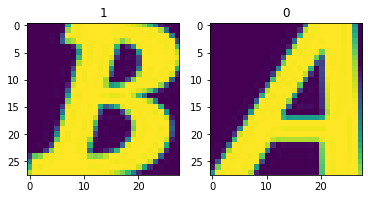

In [14]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [15]:
# shuffle — перемешивать объекты
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=1)

We can use dataloader as iterator by using iter() function.

In [16]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [18]:
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/hp/.local/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


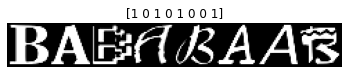

In [19]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [20]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [21]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [22]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


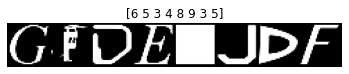

In [23]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [24]:
# сделать из квадратной картинки плоскую
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [25]:
a = Flatten()
a(img).shape

torch.Size([784])

In [26]:
img.shape

torch.Size([1, 28, 28])

In [27]:
img.view(-1).shape

torch.Size([784])

In [28]:
img.flatten().shape

torch.Size([784])

In [29]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [30]:
import time

from IPython.display import clear_output

In [31]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

/home/hp/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [32]:
# костыль дял деления данных на train и test (выбираем случайное подмножество, с которым работаем)
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [33]:
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [34]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [35]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [36]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


$$\sum_{i=1}^N p\cdot \log(q)$$

$ p = [0, 1, 0, 0, \ldots, 0] $
//
$ q = [0.2, 0.1, 0.6, 0, \ldots, 0] $

In [37]:
loss_func = nn.CrossEntropyLoss()

In [38]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [45]:
# Следующие два вывода эквивалентны
loss = loss_func(model(images.to(device)), labels.to(device))
print(loss)
loss.item()
# Так делать нельзя
# loss.data[0]

tensor(2.3333, grad_fn=<NllLossBackward>)


2.3333194255828857

In [46]:
out = model(images.to(device))
out.shape

torch.Size([32, 10])

In [73]:
out.max(dim=1)

torch.return_types.max(
values=tensor([0.7796, 0.6754, 0.7158, 0.7288, 0.8091, 0.7525, 0.5960, 0.7335, 0.8142,
        0.6334, 0.5062, 0.7061, 0.6907, 0.7233, 0.6567, 0.7336, 0.6924, 0.7046,
        0.5753, 0.6807, 0.6010, 0.7315, 0.7515, 0.7178, 0.7174, 0.7236, 0.6707,
        0.6877, 0.5338, 0.6496, 0.7258, 0.6431], grad_fn=<MaxBackward0>),
indices=tensor([8, 5, 4, 4, 5, 8, 1, 1, 3, 3, 1, 4, 0, 9, 1, 1, 1, 8, 8, 4, 0, 5, 5, 5,
        6, 9, 7, 7, 0, 4, 5, 9]))

In [47]:
# Нас волнуют только индексы
predicted_labels = out.max(dim=1)[1]

In [77]:
(predicted_labels.cpu() == labels).numpy().astype(float).sum()/len(labels)

0.09375

In [78]:
labels

tensor([1, 1, 7, 2, 8, 4, 9, 4, 3, 3, 5, 5, 9, 6, 4, 8, 4, 7, 5, 2, 4, 5, 4, 4,
        3, 0, 3, 6, 5, 5, 4, 0])

In [51]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            # переместить данные в девайс
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            # считаем предсказания
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
                out = model(X_batch)
                loss = loss_fn(out, y_batch)


                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [52]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.368s
	  training loss: 1.552365
	validation loss: 1.614093
	validation accuracy: 0.851
Epoch 2 of 30 took 0.391s
	  training loss: 1.551380
	validation loss: 1.611945
	validation accuracy: 0.849
Epoch 3 of 30 took 0.356s
	  training loss: 1.550923
	validation loss: 1.609473
	validation accuracy: 0.850
Epoch 4 of 30 took 0.378s
	  training loss: 1.549864
	validation loss: 1.613199
	validation accuracy: 0.849
Epoch 5 of 30 took 0.315s
	  training loss: 1.548643
	validation loss: 1.610879
	validation accuracy: 0.839
Epoch 6 of 30 took 0.351s
	  training loss: 1.547372
	validation loss: 1.612614
	validation accuracy: 0.852
Epoch 7 of 30 took 0.353s
	  training loss: 1.546515
	validation loss: 1.610363
	validation accuracy: 0.849
Epoch 8 of 30 took 0.344s
	  training loss: 1.545027
	validation loss: 1.612882
	validation accuracy: 0.847
Epoch 9 of 30 took 0.328s
	  training loss: 1.544254
	validation loss: 1.613511
	validation accuracy: 0.841
Epoch 10 of 30 took 0.337s
	

In [53]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

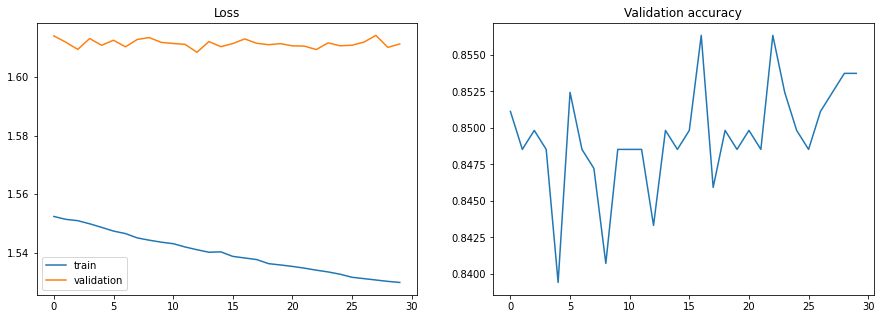

In [54]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [55]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [56]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 2.324s
	  training loss: 1.797586
	validation loss: 1.622495
	validation accuracy: 0.832
Epoch 2 of 30 took 2.189s
	  training loss: 1.622281
	validation loss: 1.587775
	validation accuracy: 0.846
Epoch 3 of 30 took 2.347s
	  training loss: 1.588167
	validation loss: 1.572715
	validation accuracy: 0.895
Epoch 4 of 30 took 2.054s
	  training loss: 1.566042
	validation loss: 1.564624
	validation accuracy: 0.889
Epoch 5 of 30 took 2.027s
	  training loss: 1.556918
	validation loss: 1.558554
	validation accuracy: 0.903
Epoch 6 of 30 took 2.168s
	  training loss: 1.551397
	validation loss: 1.552105
	validation accuracy: 0.903
Epoch 7 of 30 took 2.034s
	  training loss: 1.544035
	validation loss: 1.558876
	validation accuracy: 0.897
Epoch 8 of 30 took 1.938s
	  training loss: 1.538563
	validation loss: 1.556767
	validation accuracy: 0.898
Epoch 9 of 30 took 1.900s
	  training loss: 1.537198
	validation loss: 1.553193
	validation accuracy: 0.902
Epoch 10 of 30 took 1.954s
	

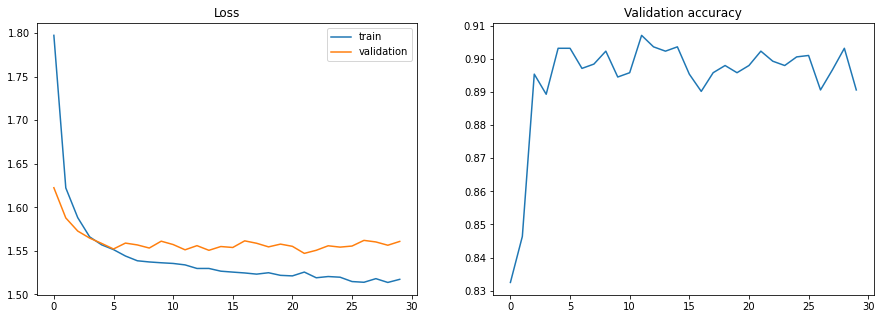

In [57]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

### Batchnorm try

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [59]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [60]:
save_checkpoint('test_save.pth', model, opt)

model saved to test_save.pth


In [61]:
from copy import copy

In [62]:
model2 = copy(model)
opt2 = copy(opt)

In [63]:
load_checkpoint('test_save.pth', model2, opt2)

model loaded from test_save.pth


In [100]:
# create a brand new model
# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
# test()

#### Define a training loop with model checkpointing

In [65]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [66]:
train_save(5, save_interval=500, log_interval=100)

NameError: name 'trainset_loader' is not defined

In [64]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

NameError: name 'Net' is not defined

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)